In [1]:
# Importing a few necessary libraries
import numpy as np
import matplotlib.pyplot as pl
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor

# Make matplotlib show our plots inline (nicely formatted in the notebook)
%matplotlib inline

# Create our client's feature set for which we will be predicting a selling price
CLIENT_FEATURES = [[11.95, 0.00, 18.100, 0, 0.6590, 5.6090, 90.00, 1.385, 24, 680.0, 20.20, 332.09, 12.13]]

# Load the Boston Housing dataset into the city_data variable
city_data = datasets.load_boston()

# Initialize the housing prices and housing features
housing_prices = city_data.target
housing_features = city_data.data

print "Boston Housing dataset loaded successfully!"

Boston Housing dataset loaded successfully!


In [2]:
# Number of houses in the dataset
total_houses = housing_features.shape[0]

# Number of features in the dataset
total_features = housing_features.shape[1]

# Minimum housing value in the dataset
minimum_price = np.min(housing_prices)

# Maximum housing value in the dataset
maximum_price = np.max(housing_prices)

# Mean house value of the dataset
mean_price = np.mean(housing_prices)

# Median house value of the dataset
median_price = np.median(housing_prices)

# Standard deviation of housing values of the dataset
std_dev = np.std(housing_prices)

# Show the calculated statistics
print "Boston Housing dataset statistics (in $1000's):\n"
print "Total number of houses:", total_houses
print "Total number of features:", total_features
print "Minimum house price:", minimum_price
print "Maximum house price:", maximum_price
print "Mean house price: {0:.3f}".format(mean_price)
print "Median house price:", median_price
print "Standard deviation of house price: {0:.3f}".format(std_dev)

Boston Housing dataset statistics (in $1000's):

Total number of houses: 506
Total number of features: 13
Minimum house price: 5.0
Maximum house price: 50.0
Mean house price: 22.533
Median house price: 21.2
Standard deviation of house price: 9.188


In [3]:
print CLIENT_FEATURES

[[11.95, 0.0, 18.1, 0, 0.659, 5.609, 90.0, 1.385, 24, 680.0, 20.2, 332.09, 12.13]]


In [4]:
from sklearn import cross_validation

def shuffle_split_data(X, y):
    """ Shuffles and splits data into 70% training and 30% testing subsets,
        then returns the training and testing subsets. """

    # Shuffle and split the data
    rs = cross_validation.ShuffleSplit(506, n_iter=1, test_size=.33, random_state=0)    
    for train_index, test_index in rs:
        X_train = X.take(train_index, axis=0)
        y_train = y[train_index]
        X_test = X.take(test_index, axis=0)
        y_test = y[test_index]

    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test


# Test shuffle_split_data
try:
    X_train, y_train, X_test, y_test = shuffle_split_data(housing_features, housing_prices)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


Successfully shuffled and split the data!


In [5]:
from sklearn.metrics import mean_squared_error

def performance_metric(y_true, y_predict):
    """ Calculates and returns the total error between true and predicted values
        based on a performance metric chosen by the student. """

    error = mean_squared_error(y_true, y_predict)
    return error


# Test performance_metric
try:
    total_error = performance_metric(y_train, y_train)
    print "Successfully performed a metric calculation!"
except:
    print "Something went wrong with performing a metric calculation."

Successfully performed a metric calculation!


In [6]:
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


def fit_model(X, y):
    """ Tunes a decision tree regressor model using GridSearchCV on the input data X 
        and target labels y and returns this optimal model. """

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Set up the parameters we wish to tune
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}

    # Make an appropriate scoring function
    scoring_function = make_scorer(mean_squared_error, greater_is_better = False)

    # Make the GridSearchCV object
    reg = GridSearchCV(regressor, 
                       param_grid = parameters,
                       scoring = scoring_function)

    # Fit the learner to the data to obtain the optimal model with tuned parameters
    reg.fit(X, y)

    # Return the optimal model
    return reg.best_estimator_


# Test fit_model on entire dataset
try:
    reg = fit_model(housing_features, housing_prices)
    print "Successfully fit a model!"
except:
    print "Something went wrong with fitting a model."

Successfully fit a model!


In [7]:
def learning_curves(X_train, y_train, X_test, y_test):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing error rates for each model are then plotted. """
    
    print "Creating learning curve graphs for max_depths of 1, 3, 6, and 10. . ."
    
    # Create the figure window
    fig = pl.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 50)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            regressor = DecisionTreeRegressor(max_depth = depth)
            
            # Fit the learner to the training data
            regressor.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, regressor.predict(X_test))

        # Subplot the learning curve graph
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
    
    # Visual aesthetics
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()

In [8]:
def model_complexity(X_train, y_train, X_test, y_test):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    print "Creating a model complexity graph. . . "

    # We will vary the max_depth of a decision tree model from 1 to 14
    max_depth = np.arange(1, 14)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth = d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, test_err, lw=2, label = 'Testing Error')
    pl.plot(max_depth, train_err, lw=2, label = 'Training Error')
    pl.legend()
    pl.xlabel('Maximum Depth')
    pl.ylabel('Total Error')
    pl.show()

Creating learning curve graphs for max_depths of 1, 3, 6, and 10. . .


C:\Users\Daddy\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


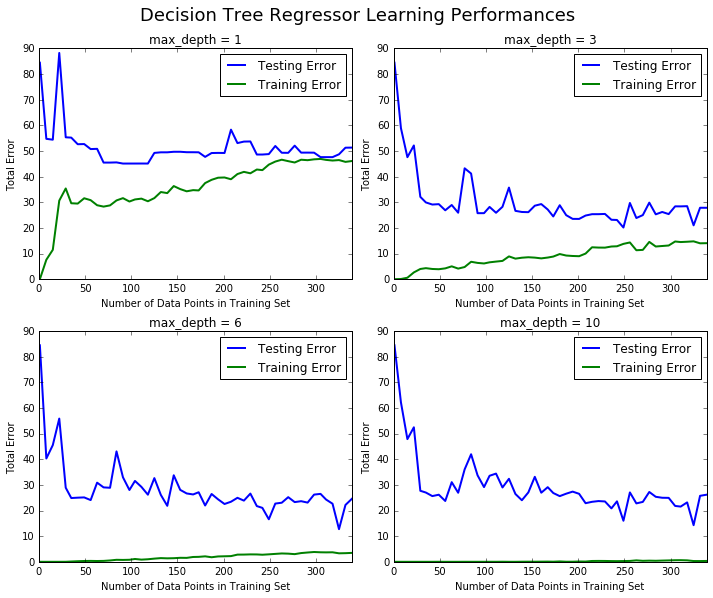

In [9]:
learning_curves(X_train, y_train, X_test, y_test)

Creating a model complexity graph. . . 


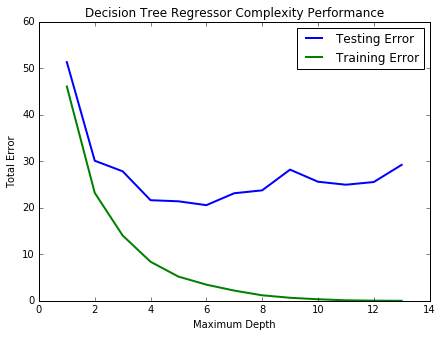

In [10]:
model_complexity(X_train, y_train, X_test, y_test)

In [11]:
print "Final model has an optimal max_depth parameter of", reg.get_params()['max_depth']

Final model has an optimal max_depth parameter of 4


In [12]:
sale_price = reg.predict(CLIENT_FEATURES)
print "Predicted value of client's home: {0:.3f}".format(sale_price[0])

Predicted value of client's home: 21.630
